In [93]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [94]:
# 读取数据
data = pd.read_csv(r'D:\ArcgisData\pred_organic\feature_table_result\N_result.csv')
data.shape

(6805, 22)

In [95]:
# 删除缺失值
# 删除有缺失值的行
data.dropna(inplace=True)
data.shape

(6805, 22)

In [96]:
data.columns,len(data.columns)

(Index(['GD_point', 'X', 'Y', 'N', 'ASP_Band_1', 'CUR_Band_1', 'DEM_Band_1',
        'DL_Band_1', 'DZ_Band_1', 'NDVI_Band_1', 'NIGTH_Band_1', 'PLCUR_Band_1',
        'POCUR_Band_1', 'PRE_Band_1', 'SLOP_Band_1', 'SOILQS_Band_1',
        'TMP_Band_1', 'TPI_101_Band_1', 'TPI_11_Band_1', 'TPI_201_Band_1',
        'TPI_3_Band_1', 'TWI_5_Band_1'],
       dtype='object'),
 22)

In [97]:
data.drop(['GD_point'], axis=1, inplace=True)
data.columns

Index(['X', 'Y', 'N', 'ASP_Band_1', 'CUR_Band_1', 'DEM_Band_1', 'DL_Band_1',
       'DZ_Band_1', 'NDVI_Band_1', 'NIGTH_Band_1', 'PLCUR_Band_1',
       'POCUR_Band_1', 'PRE_Band_1', 'SLOP_Band_1', 'SOILQS_Band_1',
       'TMP_Band_1', 'TPI_101_Band_1', 'TPI_11_Band_1', 'TPI_201_Band_1',
       'TPI_3_Band_1', 'TWI_5_Band_1'],
      dtype='object')

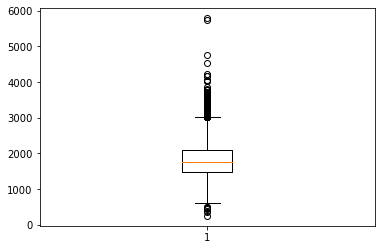

(6805, 21)


In [98]:
plt.boxplot(data["N"])
plt.show()
print(data.shape)

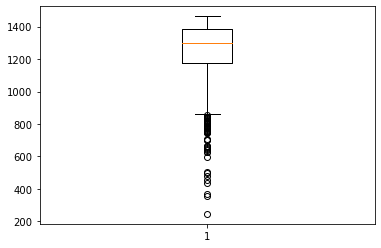

(1622, 21)


In [69]:
# 剔除离群值(3倍std)
outlier_threshold = data["N"].std()*3
s3_filter_data = data[abs(data['N']) < outlier_threshold]
s3_filter_data
plt.boxplot(s3_filter_data["N"])
plt.show()
print(s3_filter_data.shape)

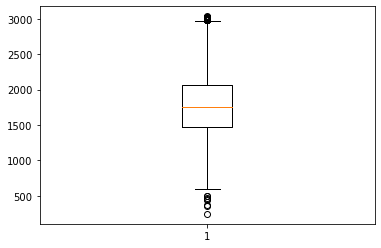

(6671, 21)


In [99]:
# 剔除离群值（Z-score）
z_scores = (data["N"]-data["N"].mean())/data["N"].std()
z_scores.describe()
# 设置阈值
z_score_filter= 2.5
z_filter_data = data[z_scores<z_score_filter]
z_filter_data
plt.boxplot(z_filter_data["N"])
plt.show()
print(z_filter_data.shape)

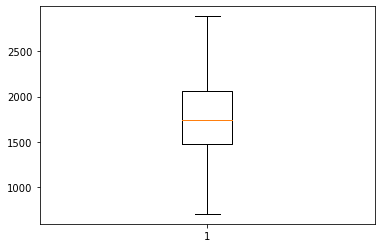

(6581, 21)


In [71]:
# 剔除离群值(IQR)
q1 = data['N'].quantile(0.25)
q3 = data['N'].quantile(0.75)
iqr = q3-q1
iqr_threshold = 1.3*iqr # 阈值1
iqr_filtered_data = data[(data['N'] >= q1 - iqr_threshold) & (data['N'] <= q3 + iqr_threshold)]
iqr_filtered_data
plt.boxplot(iqr_filtered_data["N"])
plt.show()
print(iqr_filtered_data.shape)

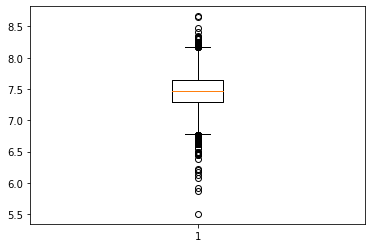

(6805, 21)


In [72]:
# log
log_data= data["N"].apply(np.log)
log_data
plt.boxplot(log_data)
plt.show()
print(data.shape)

In [100]:
data['N'].describe()

count    6805.000000
mean     1815.630713
std       488.279439
min       246.000000
25%      1475.000000
50%      1760.000000
75%      2091.000000
max      5784.000000
Name: N, dtype: float64

In [74]:
# 将label取为对数做训练
# data['organic'] = data['organic'].apply(np.log)
# 取z_score化后的数据做训练
data = z_filter_data
data.shape

(6671, 21)

In [75]:
data['N'].describe()

count    6671.000000
mean     1784.162794
std       435.092526
min       246.000000
25%      1470.500000
50%      1750.000000
75%      2070.000000
max      3036.000000
Name: N, dtype: float64

In [76]:
data.columns

Index(['X', 'Y', 'N', 'ASP_Band_1', 'CUR_Band_1', 'DEM_Band_1', 'DL_Band_1',
       'DZ_Band_1', 'NDVI_Band_1', 'NIGTH_Band_1', 'PLCUR_Band_1',
       'POCUR_Band_1', 'PRE_Band_1', 'SLOP_Band_1', 'SOILQS_Band_1',
       'TMP_Band_1', 'TPI_101_Band_1', 'TPI_11_Band_1', 'TPI_201_Band_1',
       'TPI_3_Band_1', 'TWI_5_Band_1'],
      dtype='object')

In [101]:
# 重命名列名称
new_colums = {"ASP_Band_1":"ASP","CUR_Band_1":"CUR","DEM_Band_1":"DEM","DL_Band_1":"DL","DZ_Band_1":"DZ","NDVI_Band_1":"NDVI","NIGTH_Band_1":"NIGHT","PLCUR_Band_1":"PLCUR","POCUR_Band_1":"POCUR","PRE_Band_1":"PRE","SLOP_Band_1":"SLOPE",
              "SOILQS_Band_1":"SOILQS","TMP_Band_1":"TMP","TPI_101_Band_1":"TPI101","TPI_11_Band_1":"TPI11","TPI_201_Band_1":"TPI201","TPI_3_Band_1":"TPI3","TWI_5_Band_1":"TWI5"}
data.rename(columns=new_colums,inplace=True)
data.columns,len(data.columns)

(Index(['X', 'Y', 'N', 'ASP', 'CUR', 'DEM', 'DL', 'DZ', 'NDVI', 'NIGHT',
        'PLCUR', 'POCUR', 'PRE', 'SLOPE', 'SOILQS', 'TMP', 'TPI101', 'TPI11',
        'TPI201', 'TPI3', 'TWI5'],
       dtype='object'),
 21)

In [102]:
data.columns

Index(['X', 'Y', 'N', 'ASP', 'CUR', 'DEM', 'DL', 'DZ', 'NDVI', 'NIGHT',
       'PLCUR', 'POCUR', 'PRE', 'SLOPE', 'SOILQS', 'TMP', 'TPI101', 'TPI11',
       'TPI201', 'TPI3', 'TWI5'],
      dtype='object')

In [103]:
# 筛选特征因子进行训练
f_data= data[['X', 'Y', 'N', 'ASP', 'DEM', 'DL', 'NDVI', 'NIGHT', 'PRE', 'SLOPE', 'SOILQS', 'TMP', 'TPI11', 'TPI101','TPI201','TPI3','TWI5','DZ']]
f_data.columns

Index(['X', 'Y', 'N', 'ASP', 'DEM', 'DL', 'NDVI', 'NIGHT', 'PRE', 'SLOPE',
       'SOILQS', 'TMP', 'TPI11', 'TPI101', 'TPI201', 'TPI3', 'TWI5', 'DZ'],
      dtype='object')

In [104]:
# 将目标值范围缩小
f_data.loc[:,'N']=f_data['N'].div(1000)

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [105]:
f_data

,X,Y,N,ASP,DEM,DL,NDVI,NIGHT,PRE,SLOPE,SOILQS,TMP,TPI11,TPI101,TPI201,TPI3,TWI5,DZ
0,421468.3773,3.084265e+06,1.486,277.943970,885.099976,3,653.0,0.39,811.333313,23.468807,12,159.416672,0.157227,10.274841,15.477661,0.025696,5.962960,2.0
1,400808.6671,3.135376e+06,1.402,71.036064,1270.500000,3,983.0,0.19,846.750000,34.398079,11,138.666672,-4.790527,-20.338257,20.920898,-0.400513,8.513925,2.0
2,401090.4877,3.135560e+06,1.885,63.435398,1162.699951,3,983.0,0.21,846.750000,19.115973,11,138.666672,-1.263062,-31.960815,-70.393555,-0.061768,6.150497,2.0
3,401713.9453,3.134558e+06,1.623,84.494598,1013.599976,3,97.0,0.20,834.333313,22.632359,12,148.750000,0.508789,-14.295593,-12.195618,0.033875,5.421333,2.0
4,401304.5464,3.134352e+06,1.325,150.833389,1084.000000,3,97.0,0.21,831.333313,13.832514,11,152.500000,-0.085693,22.754883,57.751343,0.006958,6.967052,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6800,448515.8424,3.099514e+06,3.055,291.983063,1177.400024,8,6127.0,0.22,859.500000,30.444139,11,140.916672,-2.785400,-45.670776,-49.450928,-0.210083,8.990523,3.0
6801,406955.8942,3.080183e+06,4.064,297.898590,934.299988,7,6166.0,0.33,808.333313,2.753100,11,157.333328,0.031860,-10.025513,-43.540405,0.003784,10.252124,1.0
6802,406844.5513,3.079833e+06,1.908,45.000000,940.099976,7,5944.0,0.37,807.666687,1.417734,11,157.833328,-0.095154,-13.003418,-32.677429,-0.006409,7.875397,1.0
6803,407051.3894,3.079794e+06,1.552,280.304626,965.000000,3,5944.0,0.37,808.333313,12.604443,11,157.333328,-0.225037,-6.552490,-31.092773,-0.023010,6.314113,1.0


In [106]:
# 划分测试数据
train_data = f_data.sample(frac=0.8,random_state=0)   # 80%的数据用于训练
test_data = f_data.drop(train_data.index)                 # 20%的数据用于测试
train_data.sample()

,X,Y,N,ASP,DEM,DL,NDVI,NIGHT,PRE,SLOPE,SOILQS,TMP,TPI11,TPI101,TPI201,TPI3,TWI5,DZ
4204,430373.7967,3.145333e+06,1.673,307.349457,1013.400024,3,215.0,0.26,863.5,25.548717,11,152.166672,-0.42572,9.469116,12.318359,-0.020691,4.795113,2.0


In [107]:
label = 'N'
train_data[label].describe()

count    5444.000000
mean        1.821931
std         0.493205
min         0.246000
25%         1.478000
50%         1.763000
75%         2.103000
max         5.784000
Name: N, dtype: float64

In [108]:
# TabularPredictor.load("AutogluonModels\ag-20230802_083815\")  全要素
# TabularPredictor.load("AutogluonModels\ag-20230803_041226\")  全要素  presets="best_quality"
"""
num_stack_levels(默认值为1):用于集成多个模型时，可以指定要使用的级别数。较高的级别数可以提供更强大的模型集成能力，但可能会增加训练和推断时间。

num_bag_folds(默认值为8):用于bagging(随机森林)集成中的交叉验证折叠数。它决定了训练数据的划分和多个模型的训练次数。较大的值可以提供更准确的估计，但同时也会增加训练时间。

num_bag_sets(默认值为20):与num_bag_folds一起决定了bagging集成中的模型数量。num_bag_folds*num_bag_sets即为最终集成的模型数量。较大的值可以提供更强大的集成能力,但也会增加训练和推断时间。

这些参数用于调整集成学习过程中的细节，以获得更好的模型表现。可以根据具体的数据集和问题类型进行调整，并根据需求进行实验和调优。"""
# predictor = TabularPredictor(label=label).fit(train_data,time_limit=6000,presets="best_quality")
# 模型存放位置
model_path = r'D:\ArcgisData\pred_organic\N_pred_moudle\zscore_normal'
# model_path = r'D:\ArcgisData\pred_organic\organic_pred_moudle\对数化'
predictor = TabularPredictor(label=label,path=model_path)
# predictor.fit(train_data,time_limit=10800,presets="best_quality",num_stack_levels = 5,num_bag_folds = 5,num_bag_sets = 30)
# predictor.fit(train_data,time_limit=10800,presets="best_quality")
predictor.fit(train_data,time_limit=10800)
# predictor = TabularPredictor.load(model_path)

Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "D:\ArcgisData\pred_organic\N_pred_moudle\zscore_normal\"
AutoGluon Version:  0.8.2
Python Version:     3.9.11
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   631.99 GB / 808.56 GB (78.2%)
Train Data Rows:    5444
Train Data Columns: 17
Label Column: N
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (5.784, 0.246, 1.82193, 0.4932)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    51528.55 MB
	Train Data (Original)  Memo

In [109]:
# 获取最佳模型
best_model = predictor.get_model_best()
print(best_model)
# 获取WeightedEnsemble_L3模型
# 获取模型的训练摘要
model_summary = predictor.fit_summary()

WeightedEnsemble_L2
*** Summary of fit() ***
Estimated performance of each model:
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2  -0.375744       0.076015   3.978652                0.000000           0.140998            2       True         12
1         ExtraTreesMSE  -0.381027       0.033006   0.340994                0.033006           0.340994            1       True          7
2         LightGBMLarge  -0.383594       0.002001   0.627635                0.002001           0.627635            1       True         11
3              CatBoost  -0.385406       0.002002   1.418173                0.002002           1.418173            1       True          6
4       RandomForestMSE  -0.387636       0.032006   1.441854                0.032006           1.441854            1       True          5
5            LightGBMXT  -0.388966       0.002001   0.333699                0.002001

In [110]:
test_data

,X,Y,N,ASP,DEM,DL,NDVI,NIGHT,PRE,SLOPE,SOILQS,TMP,TPI11,TPI101,TPI201,TPI3,TWI5,DZ
0,421468.3773,3.084265e+06,1.486,277.943970,885.099976,3,653.0,0.39,811.333313,23.468807,12,159.416672,0.157227,10.274841,15.477661,0.025696,5.962960,2.0
7,401258.3506,3.132960e+06,1.948,71.565048,1060.400024,3,4283.0,0.25,831.333313,10.305770,12,152.500000,0.741699,7.871704,-0.258545,0.077026,7.379889,2.0
21,401532.7610,3.131316e+06,2.101,326.725006,1032.900024,3,7138.0,0.27,829.750000,10.833923,12,147.750000,0.301025,-13.260498,-44.576416,0.021851,5.721179,2.0
24,399913.3784,3.130650e+06,1.907,302.735748,1262.699951,22,5653.0,0.22,840.000000,26.532970,12,136.416672,0.659546,-12.660889,-19.346069,0.043945,5.277322,2.0
25,399862.5648,3.130435e+06,1.764,284.435638,1286.400024,22,5653.0,0.22,840.083313,27.540197,12,136.083328,0.083984,-18.454712,-11.868286,0.035278,5.721304,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6784,445932.9650,3.099317e+06,2.422,323.749268,1137.099976,3,5905.0,0.24,849.500000,7.942079,11,144.666672,0.316773,19.959106,40.920654,0.027710,5.784518,3.0
6785,445197.4718,3.098798e+06,1.955,116.175148,1109.300049,3,5905.0,0.20,855.166687,18.196064,11,141.583328,-0.942749,-9.528809,-0.755615,-0.081299,4.929856,1.0
6790,446161.4789,3.099219e+06,2.085,247.620010,1158.099976,4,6142.0,0.24,849.500000,7.850727,11,144.666672,0.326782,16.235840,39.580810,0.051270,5.227669,3.0
6791,446589.4368,3.099143e+06,2.163,247.479904,1173.300049,3,6142.0,0.21,855.166687,12.512379,11,141.750000,1.205444,0.353027,21.454590,0.083618,3.422246,3.0


In [111]:
# 测试数据集
y_test_pred = predictor.predict(test_data.drop(columns=[label]))
y_test = test_data[label]

In [112]:
# 训练数据集
y_train_pred = predictor.predict(train_data.drop(columns=[label]))
y_train = train_data[label]

In [113]:
# 计算残差
residuals_test =y_train - y_train_pred

In [114]:
# 高斯克里金
OK = OrdinaryKriging(train_data['X'], train_data['Y'], residuals_test, variogram_model='spherical')  # 高斯模型 linear:0.494,gaussian:0.492,exponential:0.497,spherical:0.50
kriging_predictions_test, _ = OK.execute('points', test_data['X'], test_data['Y'])
predictions_test = y_test_pred + kriging_predictions_test

# 计算R2
r2 = r2_score(y_test, predictions_test)
train_r2 = r2_score(y_train,y_train_pred)
r2,train_r2


(0.3898379684896919, 0.8262007357970673)

In [115]:

new_r2 = r2_score(y_test, y_test_pred)
new_r2


0.3826941801601347

In [28]:
# 重新计算预测值

def calc_predict_value(actual_value, predict_value):
    diff = np.abs(actual_value - predict_value)/actual_value
    modified_diff = np.where(diff <= 0.15, actual_value, predict_value)
    return modified_diff


In [52]:
t_pred = calc_predict_value(test_data[label],y_test_pred)
t_pred

array([24.1       , 28.82807922, 29.93417931, ..., 35.1507988 ,
       37.56521988, 34.9       ])

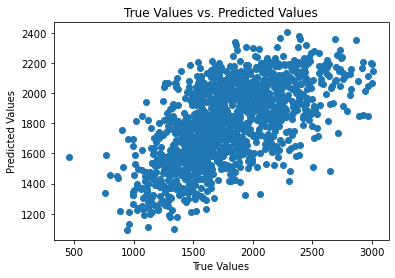

In [92]:
plt.scatter(y_test, predictions_test)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

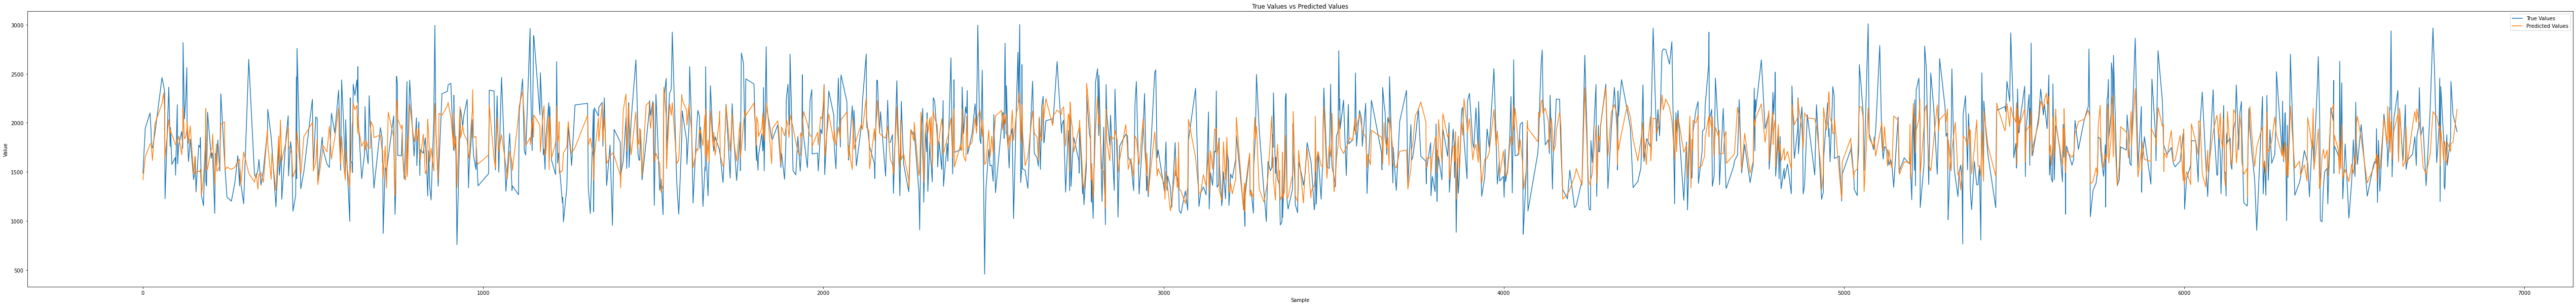

In [93]:
# 创建折线图
plt.figure(figsize=(90,10))
plt.plot(y_test, label='True Values')
plt.plot(predictions_test, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [94]:
metrics = predictor.evaluate(test_data, silent=True)

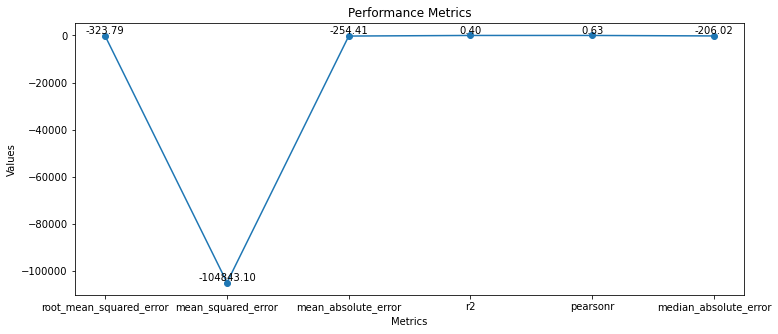

In [95]:
metric_names = list(metrics.keys())
metric_values = list(metrics.values())
plt.figure(figsize=(12,5))
plt.plot(metric_names, metric_values, marker='o')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics')

# 标注数值
for i in range(len(metric_names)):
    plt.annotate(f'{metric_values[i]:.2f}', (metric_names[i], metric_values[i]), ha='center', va='bottom')

plt.show()


In [36]:

def calculate_modified_r2(y_true, y_pred):
    diff = np.abs(y_true - y_pred)/y_true
    modified_diff = np.where(diff <= 0.15, 0, np.abs(y_true - y_pred))
    modified_ssr = np.sum(modified_diff**2)
    
    mean = np.mean(y_true)
    total_diff = np.sum((y_true - mean)**2)
    
    r2 = 1 - (modified_ssr / total_diff)
    return r2

print(calculate_modified_r2(test_data[label], y_test_pred))

0.4457098611774116


In [96]:
model_value = predictor.leaderboard(train_data, silent=True)

In [97]:
fetures_value = predictor.feature_importance(train_data)
fetures_value

Computing feature importance via permutation shuffling for 13 features using 5000 rows with 5 shuffle sets...
	15.31s	= Expected runtime (3.06s per shuffle set)
	5.04s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Y,89.847180,1.290485,5.105708e-09,5,92.504307,87.190054
X,86.356610,0.565914,2.212966e-10,5,87.521834,85.191386
SLOPE,75.921725,2.034132,6.177578e-08,5,80.110032,71.733419
TPI201,72.066938,1.628798,3.129032e-08,5,75.420656,68.713221
NDVI,66.452240,0.928515,4.572842e-09,5,68.364066,64.540414
DL,61.122197,0.680748,1.846118e-09,5,62.523867,59.720527
TMP,49.717828,1.553377,1.142024e-07,5,52.916253,46.519403
ASP,42.398295,0.353515,5.799354e-10,5,43.126187,41.670402
TPI101,30.712896,0.938031,1.042861e-07,5,32.644314,28.781478
TWI5,24.194758,0.262499,1.662401e-09,5,24.735246,23.654270


In [39]:
fetures_value.shape

(20, 6)

In [53]:
fetures_value

,importance,stddev,p_value,n,p99_high,p99_low
SLOPE,81.905169,1.810861,2.865453e-08,5,85.633757,78.176582
TPI201,78.244292,0.962785,2.750432e-09,5,80.226680,76.261903
DL,74.074114,1.950434,5.762876e-08,5,78.090085,70.058143
Y,64.465685,1.975259,1.056378e-07,5,68.532770,60.398600
X,57.702862,0.848342,5.604669e-09,5,59.449610,55.956115
NDVI,41.020287,0.622009,6.342191e-09,5,42.301012,39.739563
TMP,39.506620,1.389210,1.831717e-07,5,42.367024,36.646217
TPI101,33.766387,1.375648,3.298467e-07,5,36.598866,30.933908
DEM,29.699184,0.381936,3.281479e-09,5,30.485596,28.912773
DZ,29.032490,0.791572,6.624831e-08,5,30.662347,27.402633


In [98]:
# 将索引添加为列

df = fetures_value
df.reset_index(level=0, inplace=True)
print(df)

     index  importance    stddev       p_value  n   p99_high    p99_low
0        Y   89.847180  1.290485  5.105708e-09  5  92.504307  87.190054
1        X   86.356610  0.565914  2.212966e-10  5  87.521834  85.191386
2    SLOPE   75.921725  2.034132  6.177578e-08  5  80.110032  71.733419
3   TPI201   72.066938  1.628798  3.129032e-08  5  75.420656  68.713221
4     NDVI   66.452240  0.928515  4.572842e-09  5  68.364066  64.540414
5       DL   61.122197  0.680748  1.846118e-09  5  62.523867  59.720527
6      TMP   49.717828  1.553377  1.142024e-07  5  52.916253  46.519403
7      ASP   42.398295  0.353515  5.799354e-10  5  43.126187  41.670402
8   TPI101   30.712896  0.938031  1.042861e-07  5  32.644314  28.781478
9     TWI5   24.194758  0.262499  1.662401e-09  5  24.735246  23.654270
10     PRE   24.169163  0.362762  6.088211e-09  5  24.916094  23.422231
11   NIGHT   22.115611  0.224345  1.270545e-09  5  22.577540  21.653682
12      DZ   16.682397  0.961957  1.320833e-06  5  18.663080  14

In [55]:
fetures_value.columns

Index(['index', 'importance', 'stddev', 'p_value', 'n', 'p99_high', 'p99_low'], dtype='object')

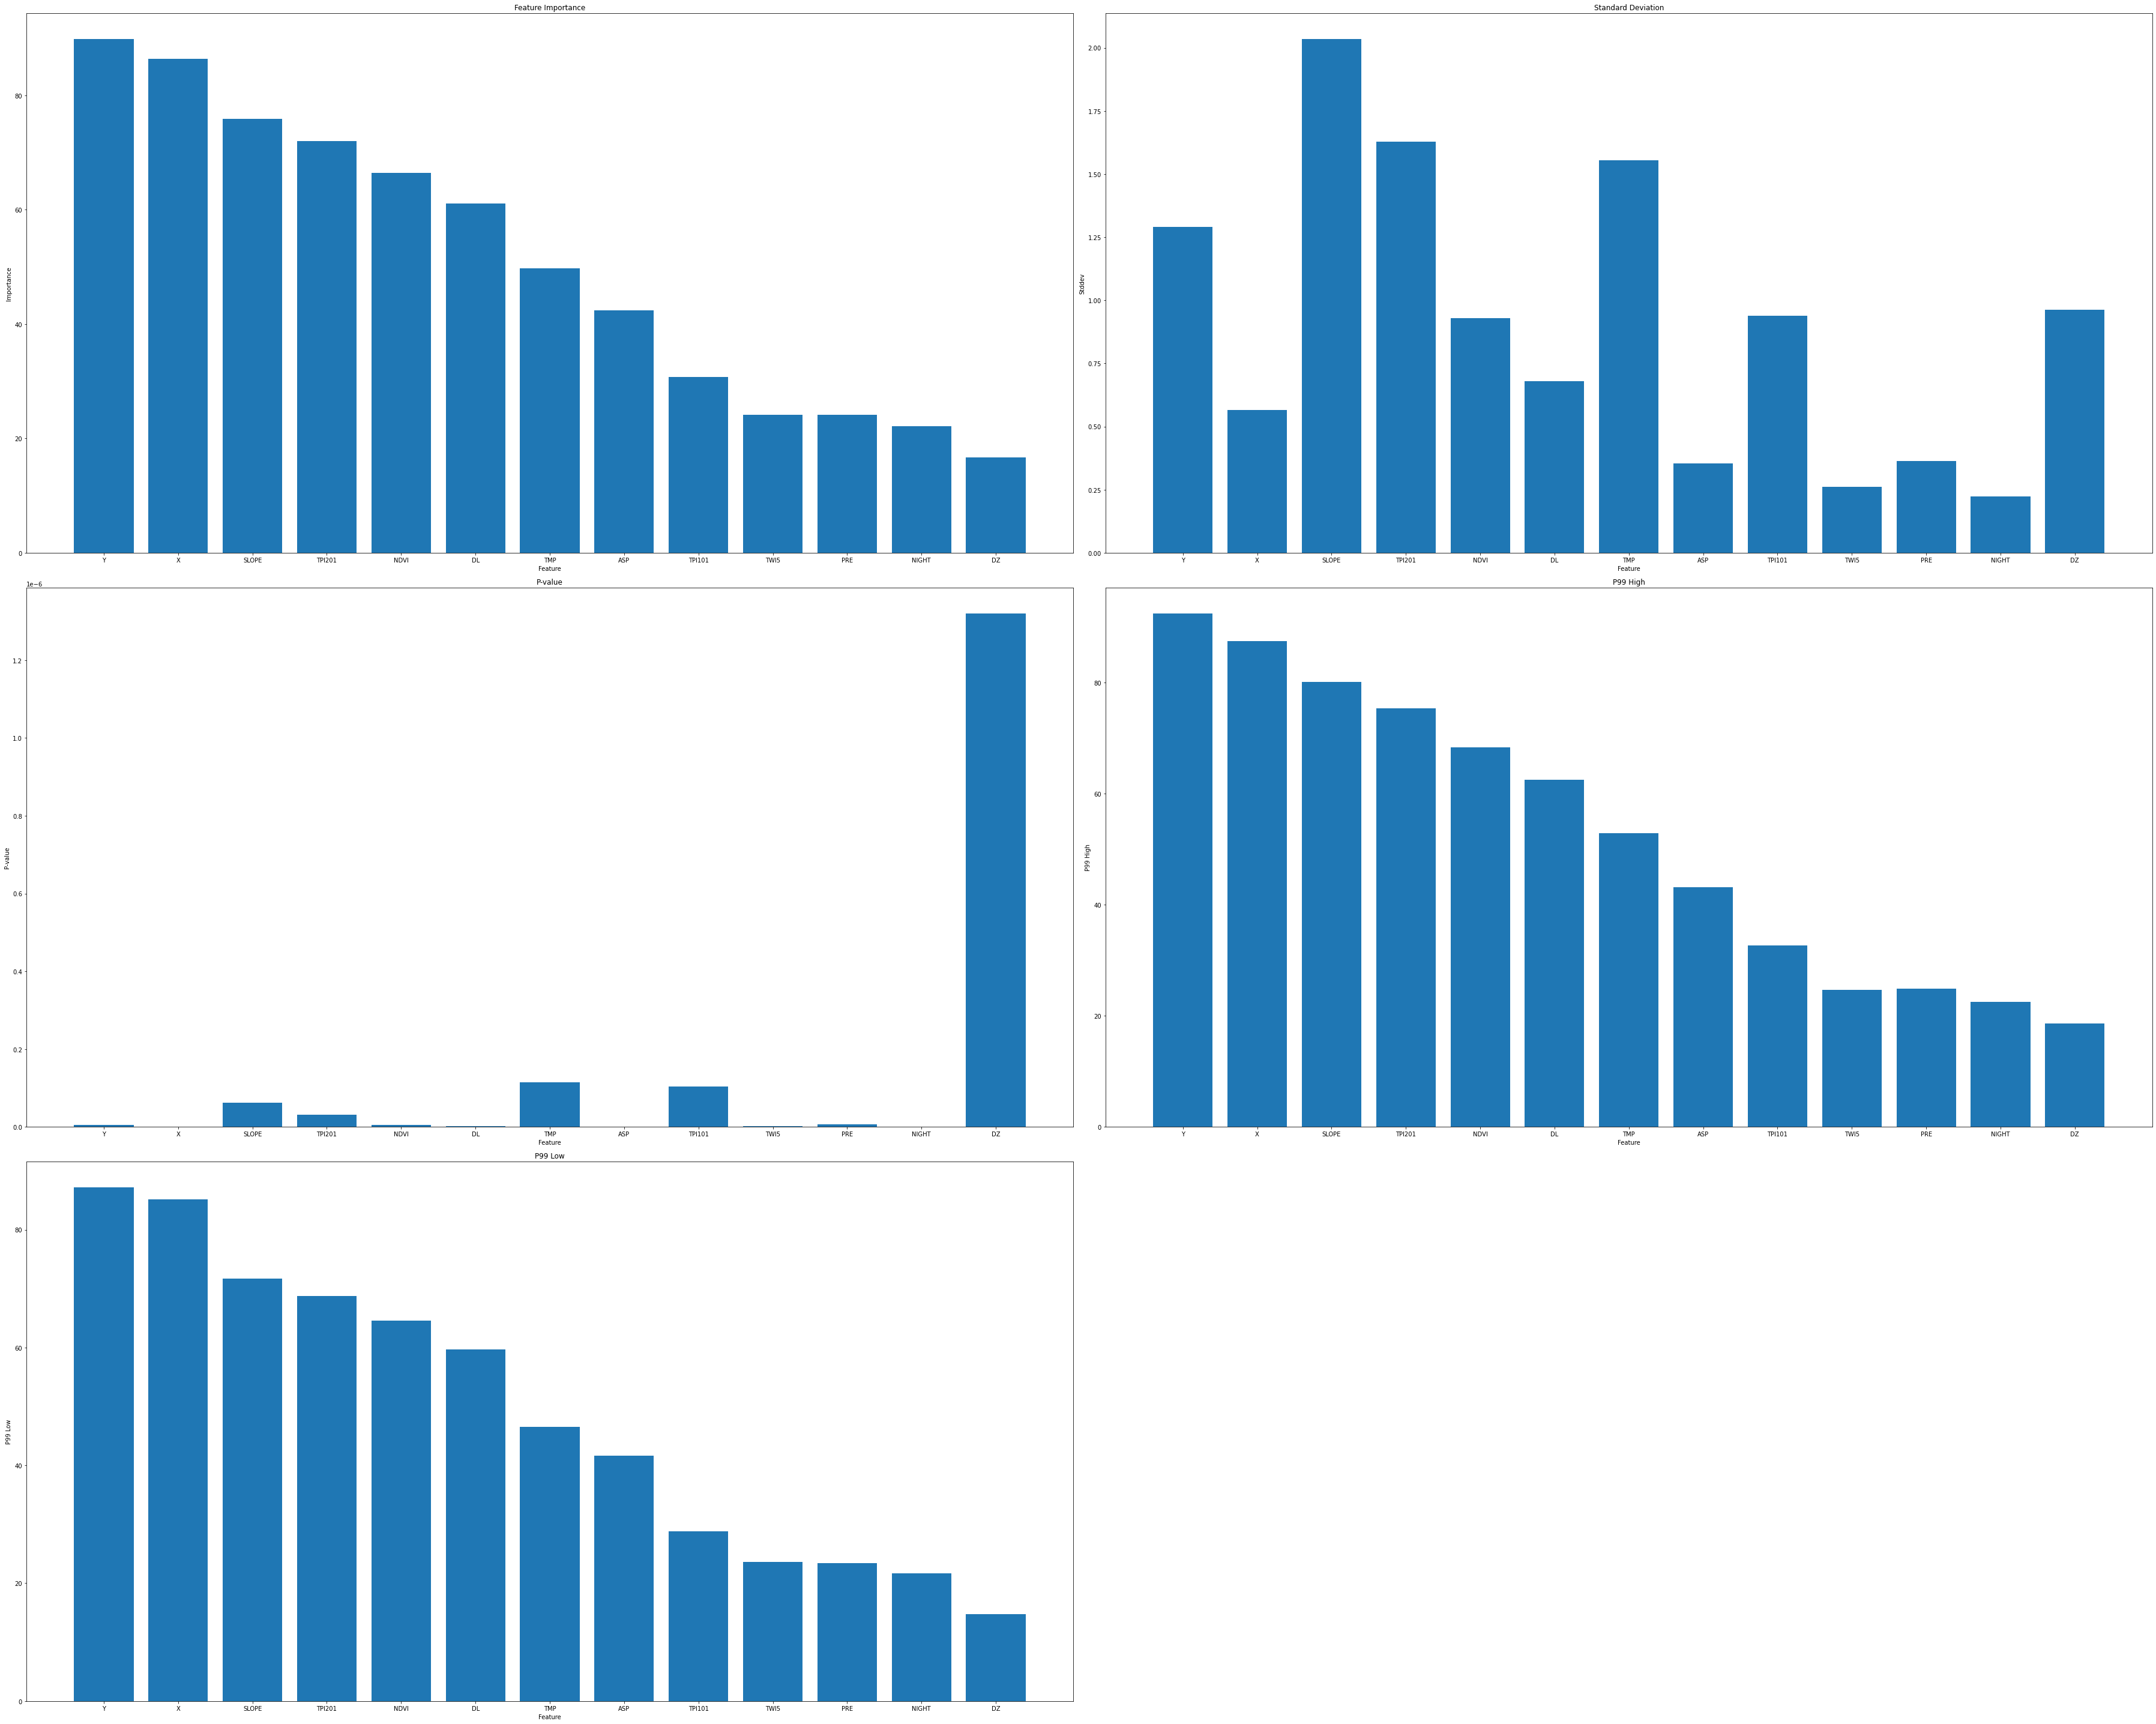

In [99]:
import matplotlib.pyplot as plt

# 设置图表大小
plt.figure(figsize=(50, 40))

# 绘制各个特征的重要性
plt.subplot(3, 2, 1)
plt.bar(df['index'], df['importance'])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')

# 绘制各个特征的标准差
plt.subplot(3, 2, 2)
plt.bar(df['index'], df['stddev'])
plt.title('Standard Deviation')
plt.xlabel('Feature')
plt.ylabel('Stddev')

# 绘制各个特征的p值
plt.subplot(3, 2, 3)
plt.bar(df['index'], df['p_value'])
plt.title('P-value')
plt.xlabel('Feature')
plt.ylabel('P-value')

# 绘制各个特征的p99高值
plt.subplot(3, 2, 4)
plt.bar(df['index'], df['p99_high'])
plt.title('P99 High')
plt.xlabel('Feature')
plt.ylabel('P99 High')

# 绘制各个特征的p99低值
plt.subplot(3, 2, 5)
plt.bar(df['index'], df['p99_low'])
plt.title('P99 Low')
plt.xlabel('Feature')
plt.ylabel('P99 Low')

# 调整子图之间的间距
plt.tight_layout()

# 展示图表
plt.show()


In [ ]:
"""importance（重要性）：

取值范围：通常是一个非负实数，可以是介于0到无穷大之间的任意值。
意义：表示该特征对目标变量的预测能力的贡献程度。重要性值越高，说明该特征在预测模型中的影响力越大。
stddev（标准差）：

取值范围：通常是一个非负实数，可以是大于等于0的任意值。
意义：衡量特征值分散程度的统计指标。标准差值越大，表示样本数据在该特征上的波动越大。
p_value（P值）：

取值范围：通常是一个小于等于1的实数，可能是非负实数或者在特定情况下限制在0到1之间的实数。
意义：用于判断某个变量对目标变量是否具有显著影响。较小的p-value表示该特征与目标变量之间的关系更显著。
n（样本数量）：

取值范围：通常是一个正整数，表示用于计算这些特征参数的样本数量。
意义：表示用于计算特征参数的数据样本的数量。
p99_high（99%置信度上限）和p99_low（99%置信度下限）：

取值范围：通常是实数，可以是任意实数或在特定情况下限制在一定范围内的实数。
意义：表示特征的置信区间。在统计意义下，特征取值不会超过上限或低于下限的概率为99%。"""